Classes: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']
Total images: 3,235
Per-class counts (label_id: count): {0: 160, 1: 82, 2: 108, 3: 129, 4: 344, 5: 280, 6: 130, 7: 128, 8: 112, 9: 280, 10: 84, 11: 80, 12: 156, 13: 178, 14: 132, 15: 260, 16: 100, 17: 158, 18: 150, 19: 184}
Train: 2,263 images across 20 classes
  sample distribution (class, count, % of split):
    - clio                    240  ( 10.6%)
    - duster                  196  (  8.7%)
    - megane                  196  (  8.7%)
    - sandero                 182  (  8.0%)
    - volkswagen tiguan       128  (  5.7%)
    - picanto                 124  (  5.5%)
    - Golf                    112  (  4.9%)
    - symbol                  110  (  4.9%)
    - octavia                 110  (  4.9%)
    - toyot

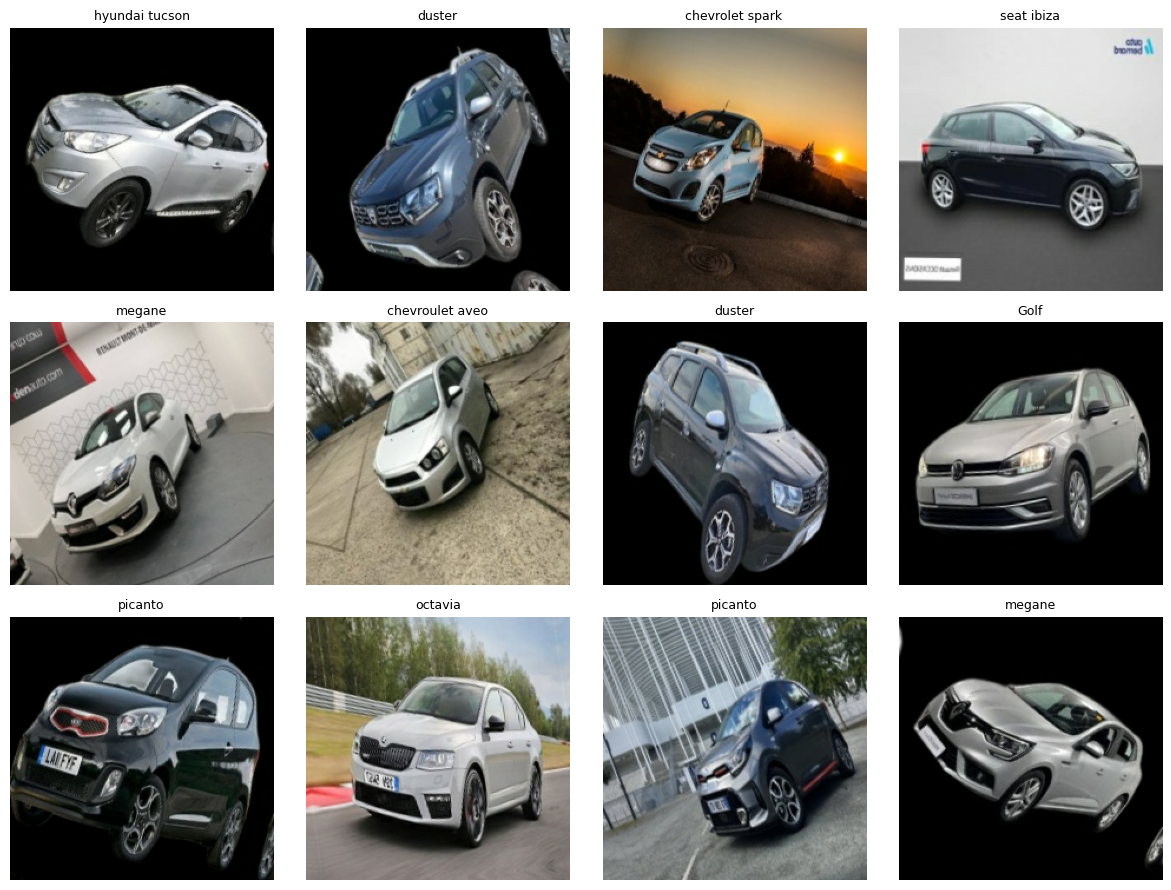

Train batches: 71
Val   batches: 16
Test  batches: 16


In [12]:
import os, math, random
from pathlib import Path
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For stratified splits
from sklearn.model_selection import train_test_split


DATA_DIR = Path("A:\Softwares\ML\Projects\Cars\dataset\DATA")  # <-- set this to your dataset root
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Desired split (must sum to 1.0)
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6, "Splits must sum to 1.0"

ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}

def find_classes(root: Path):
    
    classes = sorted([p.name for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")])
    if not classes:
        raise RuntimeError(f"No class folders found under: {root}")
    return classes

classes = find_classes(DATA_DIR)
class_to_idx = {c:i for i, c in enumerate(classes)}
print("Classes:", classes)

def list_images_and_labels(root: Path):
    paths, labels = [], []
    for cls in classes:
        cdir = root / cls
        for p in cdir.rglob("*"):
            if p.is_file() and p.suffix.lower() in ALLOWED_EXTS:
                paths.append(str(p))
                labels.append(class_to_idx[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

paths, labels = list_images_and_labels(DATA_DIR)
print(f"Total images: {len(paths):,}")


counts = Counter(labels.tolist())
print("Per-class counts (label_id: count):", dict(counts))

# First split off the test set
paths_trainval, paths_test, y_trainval, y_test = train_test_split(
    paths, labels,
    test_size=TEST_FRAC,
    stratify=labels,
    random_state=SEED,
)

# Then split train vs val from the remaining
val_adjusted = VAL_FRAC / (TRAIN_FRAC + VAL_FRAC)  # fraction of train+val that should be validation
paths_train, paths_val, y_train, y_val = train_test_split(
    paths_trainval, y_trainval,
    test_size=val_adjusted,
    stratify=y_trainval,
    random_state=SEED,
)

def summarize_split(name, y):
    cnt = Counter(y.tolist())
    total = len(y)
    top = sorted(((classes[k], v, 100.0*v/total) for k, v in cnt.items()), key=lambda x: -x[1])
    print(f"{name}: {total:,} images across {len(cnt)} classes")
    print("  sample distribution (class, count, % of split):")
    for cls_name, v, pct in top[:10]:
        print(f"    - {cls_name:<20} {v:>6}  ({pct:5.1f}%)")
    print()

summarize_split("Train", y_train)
summarize_split("Val",   y_val)
summarize_split("Test",  y_test)

AUTOTUNE = tf.data.AUTOTUNE

def decode_resize_normalize(path, label):
    # path: scalar string tensor
    img_bytes = tf.io.read_file(path)
    # Use decode_image to handle multiple formats; set channels=3
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # make shape static for map fusion
    
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), 
    ],
    name="data_augmentation",
)

def make_ds(paths_np, labels_np, training: bool):
    ds = tf.data.Dataset.from_tensor_slices((paths_np, labels_np))
    if training:
        ds = ds.shuffle(buffer_size=min(1000, len(paths_np)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    if training:
        # apply augmentation only on training
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(paths_train, y_train, training=True)
val_ds   = make_ds(paths_val,   y_val,   training=False)
test_ds  = make_ds(paths_test,  y_test,  training=False)

import matplotlib.pyplot as plt

def show_batch(ds, class_names, max_images=12):
    batch = next(iter(ds))
    images, labels = batch
    images = images.numpy()
    labels = labels.numpy()

    n = min(max_images, images.shape[0])
    cols = min(4, n)
    rows = int(math.ceil(n / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        lab = class_names[int(labels[i])]
        plt.title(lab, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds, classes, max_images=12)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val   batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test  batches:", tf.data.experimental.cardinality(test_ds).numpy())



In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path


IMG_SIZE = (224, 224)
NUM_CLASSES = len(classes)          # from your earlier pipeline
SEED = 42


from tensorflow.keras.applications import efficientnet_v2

# NOTE: our input pipeline produced images in [0,1].
# EfficientNetV2 preprocess expects 0..255 then internal normalization.
# We multiply by 255 before calling preprocess_input to match the pretrained stats.
def preprocess_for_efficientnet(x):
    x = x * 255.0
    return efficientnet_v2.preprocess_input(x)

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = layers.Lambda(preprocess_for_efficientnet, name="imagenet_preprocess")(inputs)

base = efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_tensor=x
)
base.trainable = False  

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)  # cast back if using mixed precision
model = keras.Model(inputs, outputs, name="car_brand_efficientnetv2b0")


# EarlyStopping, LR scheduler, Checkpoint

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_effnetv2b0.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

# Uses y_train from your earlier split (np array of class ids).
# If you don't have y_train here, skip class_weight or compute it where you split.
try:
    import numpy as np
    from sklearn.utils.class_weight import compute_class_weight
    classes_ids = np.arange(NUM_CLASSES)
    class_weight_vec = compute_class_weight(
        class_weight="balanced", classes=classes_ids, y=y_train  # y_train from your split
    )
    class_weight = {i: float(w) for i, w in enumerate(class_weight_vec)}
    print("Using class weights:", class_weight)
except Exception as e:
    class_weight = None
    print("Class weights disabled:", e)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_on_plateau, ckpt_cb],
    class_weight=class_weight,
    verbose=1,
)


# Unfreeze top N blocks; a simple rule: unfreeze last 30% of layers.
# You can tailor this by name (e.g., unfreeze blocks "block6" onward).
for layer in base.layers[int(0.7 * len(base.layers)):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Lower LR for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_on_plateau, ckpt_cb],
    class_weight=class_weight,
    verbose=1,
)


# Evaluate on test set

test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))


24274472/24274472 [==============================] - 2s 0us/step
Using class weights: {0: 1.0102678571428572, 1: 1.9508620689655172, 2: 1.4888157894736842, 3: 1.2434065934065934, 4: 0.4714583333333333, 5: 0.577295918367347, 6: 1.2434065934065934, 7: 1.2572222222222222, 8: 1.4506410256410256, 9: 0.577295918367347, 10: 1.9508620689655172, 11: 2.0205357142857143, 12: 1.0286363636363636, 13: 0.9125, 14: 1.2298913043478261, 15: 0.6217032967032967, 16: 1.6164285714285713, 17: 1.0286363636363636, 18: 1.0776190476190477, 19: 0.883984375}
Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 2.5319 - accuracy: 0.2563 - top3_acc: 0.4812
Epoch 1: val_loss improved from inf to 1.89975, saving model to best_effnetv2b0.h5


C:\Users\KIIT\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 81s 1s/step - loss: 2.5319 - accuracy: 0.2563 - top3_acc: 0.4812 - val_loss: 1.8998 - val_accuracy: 0.5123 - val_top3_acc: 0.7387 - lr: 0.0030
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 1.8340 - accuracy: 0.5007 - top3_acc: 0.7411
Epoch 2: val_loss improved from 1.89975 to 1.47902, saving model to best_effnetv2b0.h5
71/71 [==============================] - 68s 954ms/step - loss: 1.8340 - accuracy: 0.5007 - top3_acc: 0.7411 - val_loss: 1.4790 - val_accuracy: 0.6296 - val_top3_acc: 0.8663 - lr: 0.0030
Epoch 3/15
71/71 [==============================] - ETA: 0s - loss: 1.5114 - accuracy: 0.5996 - top3_acc: 0.8175
Epoch 3: val_loss improved from 1.47902 to 1.33368, saving model to best_effnetv2b0.h5
71/71 [==============================] - 69s 966ms/step - loss: 1.5114 - accuracy: 0.5996 - top3_acc: 0.8175 - val_loss: 1.3337 - val_accuracy: 0.6481 - val_top3_acc: 0.8889 - lr: 0.0030
Epoch 4/15
71/71 [========================

16/16 [==============================] - 13s 645ms/step
Test Accuracy:            0.9506
Test Top-3 Accuracy:      0.9774
Macro Precision/Recall/F1 0.9554 / 0.9539 / 0.9535
Weighted P/R/F1           0.9532 / 0.9506 / 0.9509

Per-class report:
                   precision    recall  f1-score   support

             Golf     0.9167    0.9167    0.9167        24
      bmw serie 1     1.0000    0.9167    0.9565        12
  chevrolet spark     1.0000    0.9375    0.9677        16
  chevroulet aveo     1.0000    0.8947    0.9444        19
             clio     0.9245    0.9423    0.9333        52
           duster     1.0000    0.9286    0.9630        42
      hyundai i10     0.9474    0.9474    0.9474        19
   hyundai tucson     1.0000    1.0000    1.0000        19
            logan     0.8500    1.0000    0.9189        17
           megane     0.8864    0.9286    0.9070        42
 mercedes class a     1.0000    1.0000    1.0000        13
     nemo citroen     1.0000    1.0000    1.0000

class  precision    recall        f1  support
10   mercedes class a   1.000000  1.000000  1.000000       13
7      hyundai tucson   1.000000  1.000000  1.000000       19
13            picanto   1.000000  1.000000  1.000000       27
11       nemo citroen   1.000000  1.000000  1.000000       12
19  volkswagen tiguan   1.000000  1.000000  1.000000       28
12            octavia   0.958333  1.000000  0.978723       23
2     chevrolet spark   1.000000  0.937500  0.967742       16
5              duster   1.000000  0.928571  0.962963       42
15            sandero   1.000000  0.923077  0.960000       39
1         bmw serie 1   1.000000  0.916667  0.956522       12

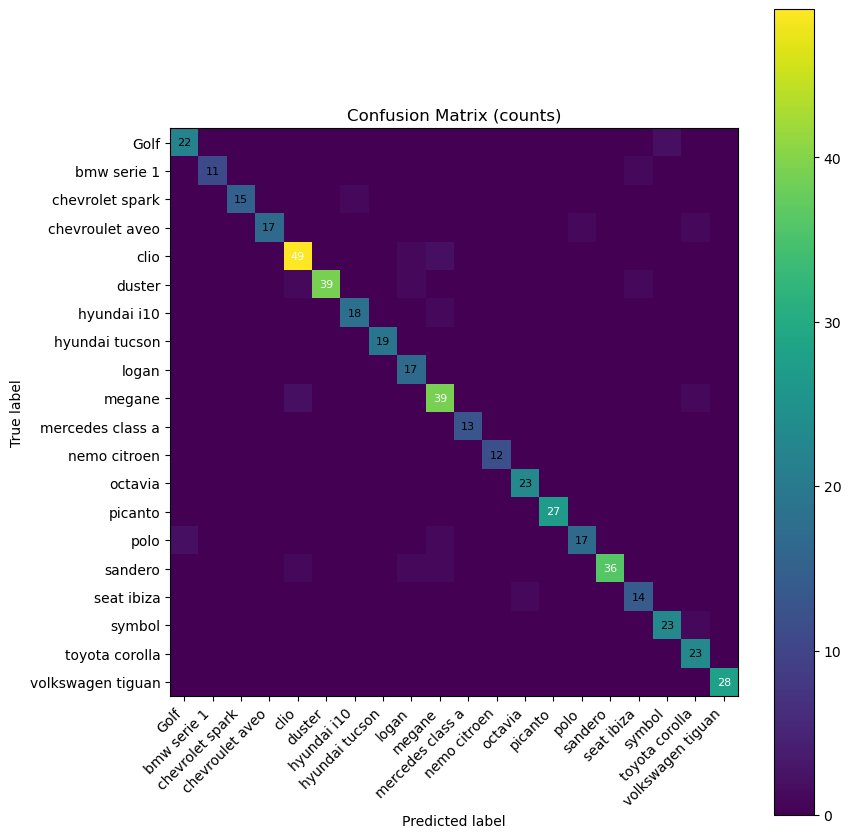

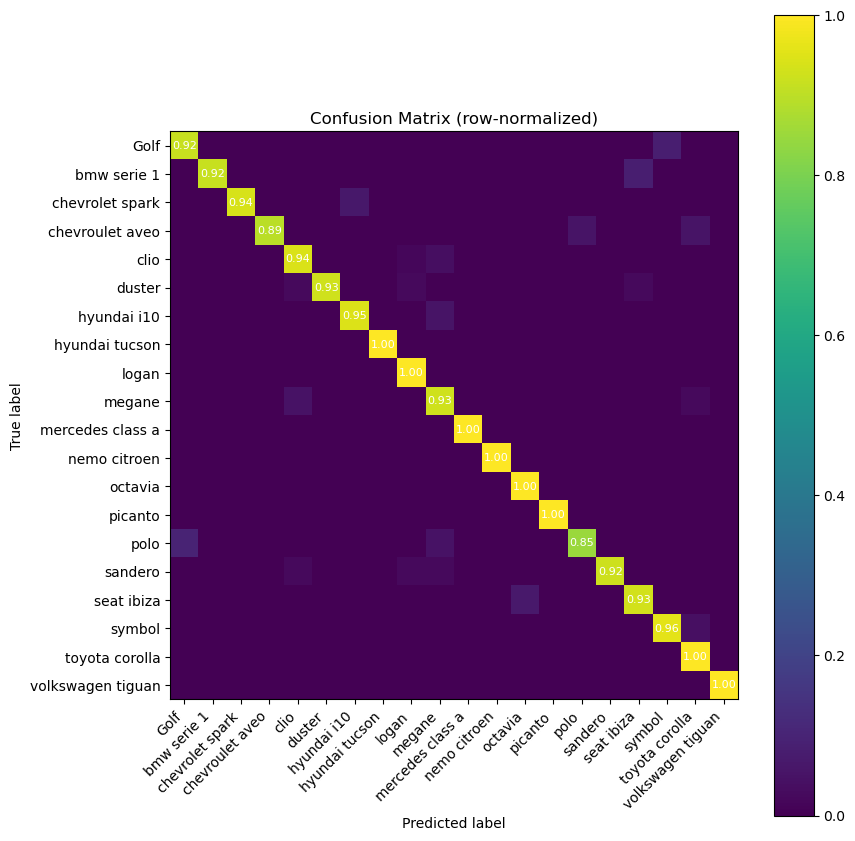

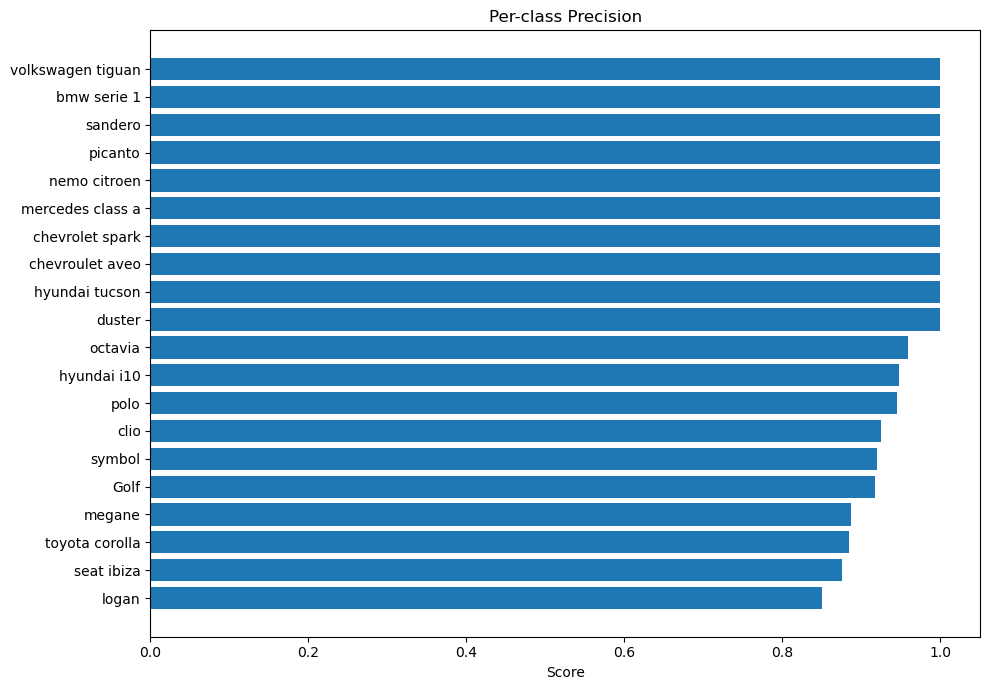

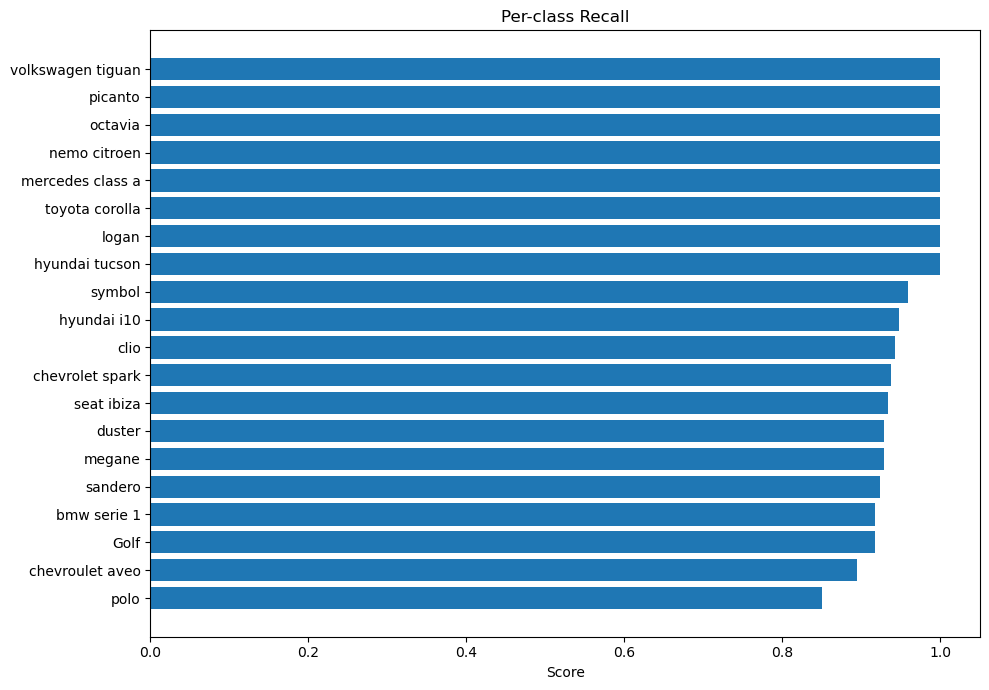

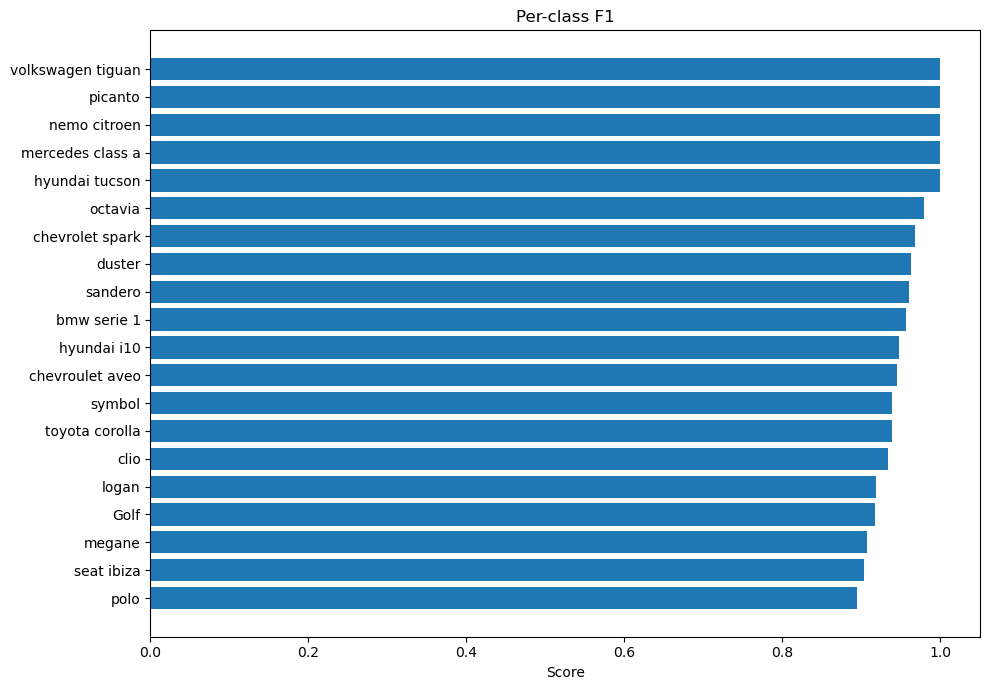


Top confusion pairs (actual -> predicted : count):
  Golf -> symbol : 2
  megane -> clio : 2
  polo -> Golf : 2
  clio -> megane : 2
  sandero -> clio : 1
  chevroulet aveo -> polo : 1
  hyundai i10 -> megane : 1
  chevroulet aveo -> toyota corolla : 1
  symbol -> toyota corolla : 1
  duster -> seat ibiza : 1


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import pandas as pd  # optional but handy

# -----------------------------
# 1) Collect labels & predictions
# -----------------------------
# y_true from dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Predicted probabilities -> labels
probs = model.predict(test_ds, verbose=1)
y_pred = probs.argmax(axis=1)

# Optional: Top-3 accuracy
top3 = np.argsort(-probs, axis=1)[:, :3]
top3_acc = np.mean([y_true[i] in top3[i] for i in range(len(y_true))])

# -----------------------------
# 2) Global metrics
# -----------------------------
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print(f"Test Accuracy:            {acc:.4f}")
print(f"Test Top-3 Accuracy:      {top3_acc:.4f}")
print(f"Macro Precision/Recall/F1 {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")
print(f"Weighted P/R/F1           {prec_weighted:.4f} / {rec_weighted:.4f} / {f1_weighted:.4f}")

# Text classification report
print("\nPer-class report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4, zero_division=0))

# -----------------------------
# 3) Per-class table (for plotting/saving)
# -----------------------------
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(classes)), zero_division=0
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
}).sort_values("f1", ascending=False)
display(per_class_df.head(10))  # in notebooks; otherwise print(per_class_df.head(10))

# -----------------------------
# 4) Confusion matrices
# -----------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

def plot_confusion_matrix(mat, class_names, title="Confusion matrix", normalize=False):
    n = len(class_names)
    fig, ax = plt.subplots(figsize=(max(6, 0.45*n), max(6, 0.45*n)))
    im = ax.imshow(mat, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(n), yticks=np.arange(n),
        xticklabels=class_names, yticklabels=class_names,
        ylabel="True label", xlabel="Predicted label", title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    # Annotate a subset (to avoid clutter for large n)
    thresh = mat.max() / 2.0
    for i in range(n):
        for j in range(n):
            val = mat[i, j]
            if normalize:
                txt = f"{val:.2f}" if np.isfinite(val) else "0.00"
            else:
                txt = f"{int(val)}"
            # Show only top cells or diagonals to keep it readable for many classes
            if (i == j) or (val >= np.percentile(mat, 95)):
                ax.text(j, i, txt, ha="center", va="center",
                        color="white" if val > thresh else "black", fontsize=8)
    fig.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes, title="Confusion Matrix (counts)", normalize=False)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix (row-normalized)", normalize=True)

# -----------------------------
# 5) Bar charts: per-class Precision/Recall/F1
# -----------------------------
def plot_bars(metric_values, title):
    order = np.argsort(metric_values)  # ascending
    vals = metric_values[order]
    labels = np.array(classes)[order]
    plt.figure(figsize=(10, max(4, 0.35*len(labels))))
    plt.barh(range(len(labels)), vals)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_bars(prec, "Per-class Precision")
plot_bars(rec,  "Per-class Recall")
plot_bars(f1,   "Per-class F1")

# -----------------------------
# 6) Top confusions (where the model most often mixes brands)
# -----------------------------
cm_offdiag = cm.copy()
np.fill_diagonal(cm_offdiag, 0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_offdiag.ravel())[::-1], cm_offdiag.shape))[0]
print("\nTop confusion pairs (actual -> predicted : count):")
reported = set()
for i, j in pairs:
    c = cm_offdiag[i, j]
    if c <= 0:
        break
    key = (i, j)
    if key in reported:
        continue
    reported.add(key)
    print(f"  {classes[i]} -> {classes[j]} : {c}")
    if len(reported) >= 10:  # top 10
        break


[Grad-CAM] Using last conv layer: top_conv


C:\Users\KIIT\AppData\Local\Temp\ipykernel_23504\481046518.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap(cmap)(heatmap_01)[..., :3]


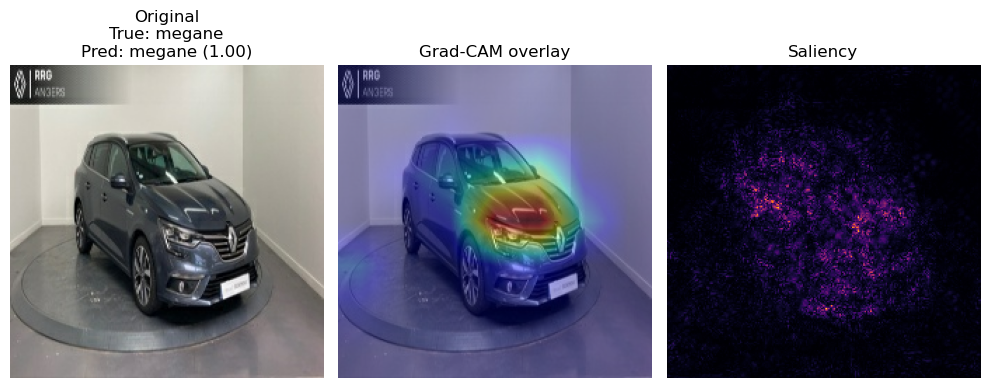

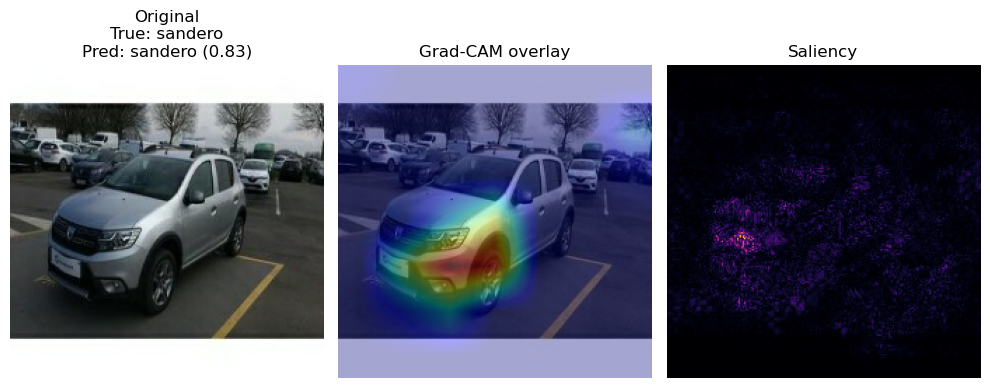

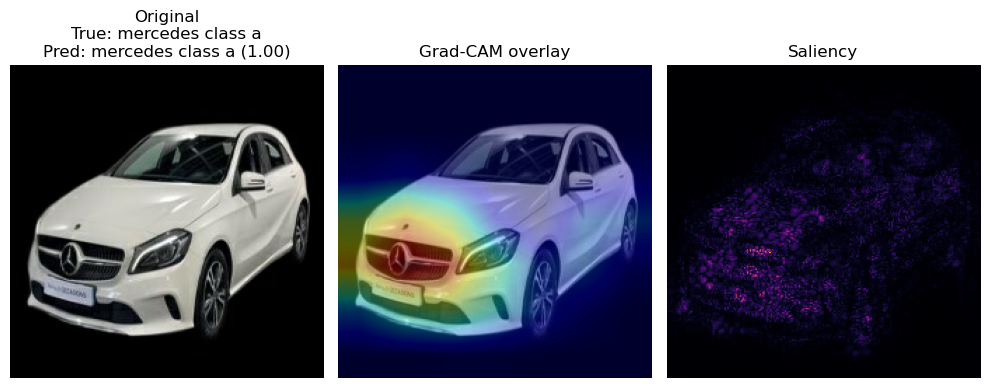

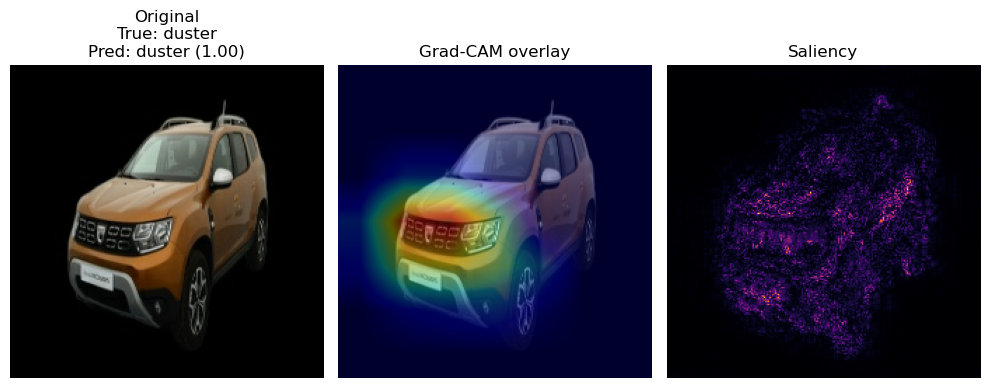

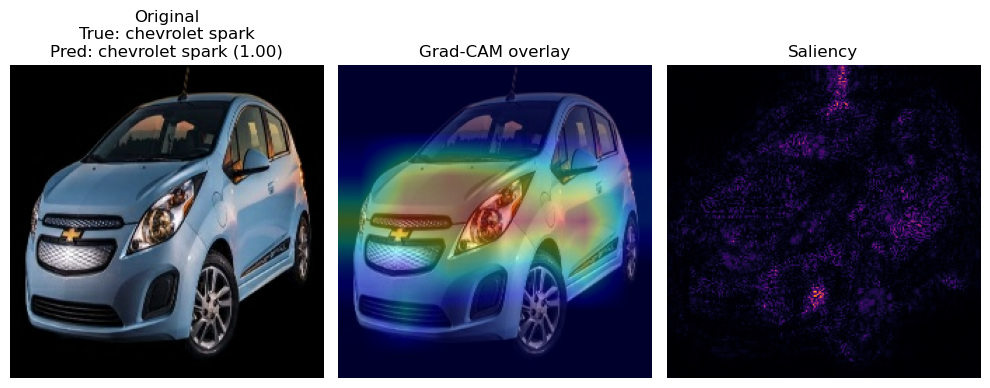

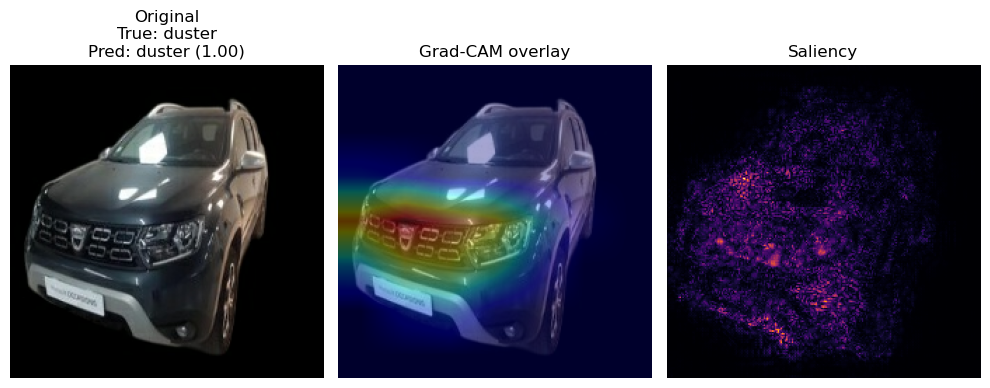

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.cm as cm

IMG_SIZE = (224, 224)

# -------------------------------
# Helpers
# -------------------------------
def _iter_layers_recursive(layer):
    if isinstance(layer, keras.Model):
        for sub in layer.layers:
            yield from _iter_layers_recursive(sub)
    yield layer

def find_last_conv_layer(model):
    conv_types = (layers.Conv2D, layers.DepthwiseConv2D, layers.SeparableConv2D)
    candidates = [l for l in _iter_layers_recursive(model) if isinstance(l, conv_types)]
    if not candidates:
        raise ValueError("No Conv2D-like layer found. Pass a conv layer explicitly.")
    last = candidates[-1]
    print(f"[Grad-CAM] Using last conv layer: {last.name}")
    return last

def _to_py_int(x):
    """Return a plain Python int from int/np.ndarray/tf.Tensor/None."""
    if x is None:
        return None
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, (np.ndarray,)):
        return int(np.array(x).item())
    if isinstance(x, tf.Tensor):
        return int(x.numpy().item())
    return int(x)

# -------------------------------
# Grad-CAM (fixed: no .numpy() on ints)
# -------------------------------
def make_gradcam_heatmap(img_01_batched, model, last_conv_layer=None, class_index=None):
    """
    img_01_batched: float32 tensor/ndarray [1,H,W,3] in [0,1]
    returns: (heatmap[H,W] in [0,1], target_class_idx int)
    """
    x = tf.convert_to_tensor(img_01_batched, dtype=tf.float32)
    if x.shape.rank != 4 or x.shape[0] != 1:
        raise ValueError("img_01_batched must have shape [1,H,W,3].")

    if last_conv_layer is None:
        last_conv_layer = find_last_conv_layer(model)

    preds_tensor = model.output
    if isinstance(preds_tensor, (list, tuple)):
        preds_tensor = preds_tensor[0]

    conv_tensor = last_conv_layer.output
    grad_model = keras.Model(inputs=model.input, outputs=[conv_tensor, preds_tensor])

    with tf.GradientTape() as tape:
        conv_maps, preds = grad_model(x, training=False)   # conv_maps: [1,h,w,c]; preds: [1,num_classes]
        # Determine target class index as a plain int
        if class_index is None:
            class_index = _to_py_int(tf.argmax(preds[0]))
        else:
            class_index = _to_py_int(class_index)

        # Score for target class
        target_score = preds[:, class_index]               # [1]

    grads = tape.gradient(target_score, conv_maps)         # [1,h,w,c]
    if grads is None:
        raise RuntimeError("Gradients are None. Ensure the chosen conv layer is in the graph.")

    weights = tf.reduce_mean(grads, axis=(1, 2))[0]        # [c]
    conv_maps = conv_maps[0]                                # [h,w,c]
    heatmap = tf.reduce_sum(conv_maps * weights, axis=-1)   # [h,w]

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = tf.image.resize(heatmap[..., None], IMG_SIZE)[..., 0]
    return heatmap.numpy(), class_index

# -------------------------------
# Saliency (fixed: no .numpy() on ints)
# -------------------------------
def saliency_map(img_01_batched, model, class_index=None):
    x = tf.convert_to_tensor(img_01_batched, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x, training=False)
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        if class_index is None:
            class_index = _to_py_int(tf.argmax(preds[0]))
        else:
            class_index = _to_py_int(class_index)
        score = preds[:, class_index]
    grads = tape.gradient(score, x)                         # [1,H,W,3]
    sal = tf.reduce_max(tf.abs(grads), axis=-1)[0]          # [H,W]
    sal = sal / (tf.reduce_max(sal) + 1e-8)
    return sal.numpy(), class_index

# -------------------------------
# Overlay + quick visualizer
# -------------------------------
def overlay_heatmap(image_01, heatmap_01, alpha=0.35, cmap="jet"):
    heatmap_01 = np.clip(heatmap_01, 0, 1)
    color = cm.get_cmap(cmap)(heatmap_01)[..., :3]
    out = (1 - alpha) * image_01 + alpha * color
    return np.clip(out, 0, 1)

def visualize_explanations(test_ds, classes, n_images=6, conv_layer=None):
    if conv_layer is None:
        conv_layer = find_last_conv_layer(model)
    shown = 0
    for batch_imgs, batch_labels in test_ds:
        for i in range(batch_imgs.shape[0]):
            if shown >= n_images:
                return
            img = batch_imgs[i].numpy()
            label = int(batch_labels[i].numpy())
            img_in = img[None, ...]

            probs = model.predict(img_in, verbose=0)
            if isinstance(probs, (list, tuple)):
                probs = probs[0]
            probs = probs[0]
            pred_idx = int(np.argmax(probs))
            pred_p  = float(probs[pred_idx])

            heat, _ = make_gradcam_heatmap(img_in, model, last_conv_layer=conv_layer, class_index=pred_idx)
            overlay = overlay_heatmap(img, heat, alpha=0.35, cmap="jet")
            sal, _ = saliency_map(img_in, model, class_index=pred_idx)

            plt.figure(figsize=(10, 6))
            plt.subplot(1, 3, 1); plt.imshow(img);     plt.title(f"Original\nTrue: {classes[label]}\nPred: {classes[pred_idx]} ({pred_p:.2f})"); plt.axis("off")
            plt.subplot(1, 3, 2); plt.imshow(overlay); plt.title("Grad-CAM overlay"); plt.axis("off")
            plt.subplot(1, 3, 3); plt.imshow(sal, cmap="inferno"); plt.title("Saliency"); plt.axis("off")
            plt.tight_layout(); plt.show()
            shown += 1

# Example run:
conv_layer = find_last_conv_layer(model)
visualize_explanations(test_ds, classes, n_images=6, conv_layer=conv_layer)
